<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/012_TensorFlow_Proj_Twelve_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source by Jason Broownlee: https://machinelearningmastery.com/

# Preprocessing

In [ ]:
# libs
import os, sys, itertools, glob
import numpy as np
import pandas as pd
from datetime import datetime
import cv2
from tqdm import tqdm
from PIL import Image
# google
from google.colab import drive
# sklearn
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# tensorflow
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.backend import clear_session
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.layers import (Input, Dense, Reshape, Flatten, PReLU,
                                     BatchNormalization, LeakyReLU,
                                     Conv2D, Conv2DTranspose, Dropout,
                                     Embedding, Concatenate, Activation,
                                     UpSampling2D, Lambda, add)
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import normalize, plot_model
# visualize
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# seed
np.random.seed(42)

In [ ]:
# versions
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.15.0


In [ ]:
# processing unit
physical_devices = tf.config.list_physical_devices("GPU")
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
# mount google drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# curr dir
os.getcwd()

'/content/drive/My Drive'

In [ ]:
# working dir
working_dir = "/content/drive/MyDrive"
os.listdir(working_dir)

['Lottery',
 'Colab Notebooks',
 'dogs-vs-cats',
 'animals',
 'LaEterna',
 'walmart',
 'amazon',
 'arff_files',
 'forest_fires',
 'secom',
 'handwritten_text',
 'fashion',
 'employee',
 'jena_climate',
 'Multi_Digit_Mnist',
 'support2.csv',
 'I-485 Read First (T5).zip',
 'NIW',
 'anomaly.csv',
 'GE.csv',
 'maps',
 'Sandstone',
 'Jupyter Notebooks']

In [ ]:
# change dir to working_dir
os.chdir(working_dir)
assert os.getcwd() == working_dir

# GAN Basic Model

In [ ]:
# funcs.
def build_generator():
  noise_shape = (100,)
  model = Sequential(name="generator")
  model.add(Dense(256, input_shape=noise_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(1024))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(np.prod(img_shape), activation="tanh"))
  model.add(Reshape(img_shape))
  model.summary()
  noise = Input(shape=noise_shape)
  fake_img = model(noise)
  return Model(noise, fake_img)

def build_discriminator():
  model = Sequential(name="discriminator")
  model.add(Flatten(input_shape=img_shape))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1, activation="sigmoid"))
  model.summary()
  img = Input(shape=img_shape)
  validity = model(img)
  return Model(img, validity)

def train_data(epochs, batch_size=128, save_interval=500):
  (X_train, _), (_, _) = mnist.load_data()
  X_train = (X_train.astype(np.float32) - 127.5) / 127.5
  X_train = np.expand_dims(X_train, axis=3)
  half_batch = int(batch_size/2)
  for epoch in range(epochs):
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]
    noise = np.random.normal(0, 1, (half_batch, 100))
    gen_imgs = generator.predict(noise)
    loss_real_img = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    loss_fake_img = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    discrim_loss = 0.5 * np.add(loss_real_img, loss_fake_img)
    noise = np.random.normal(0, 1, (batch_size, 100))
    valid_y = np.array([1] * batch_size)
    gen_loss = gan_model.train_on_batch(noise, valid_y)
    print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, discrim_loss[0], discrim_loss[1]*100, gen_loss))
    if epoch % save_interval == 0:
      save_imgs(epoch)

def save_imgs(epoch):
  r, c = 5, 5
  noise = np.random.normal(0, 1, (r * c, 100))
  gen_imgs = generator.predict(noise)
  gen_imgs = 0.5 * gen_imgs + 0.5
  fig, axs = plt.subplots(r,c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      axs[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap="gray")
      axs[i,j].axis("off")
      cnt += 1
    # fig.savefig("Images/mnist_%d.png" % epoch)
    plt.close()

In [ ]:
clear_session() # clear session
img_rows, img_cols = 28, 28
num_chanels = 1
img_shape = (img_rows, img_cols, num_chanels)
optimizer = Adam(0.0002, 0.5)
discriminator = build_discriminator()
discriminator.compile(loss="binary_crossentropy", optimizer=optimizer,
                       metrics=["accuracy"])
generator = build_generator()
generator.compile(loss="binary_crossentropy", optimizer=optimizer)
z = Input(shape=(100,))
img = generator(z)
discriminator.trainable = False
valid = discriminator(img)
gan_model = Model(z, valid, name="gan")
gan_model.compile(loss="binary_crossentropy", optimizer=optimizer)
gan_model.summary()
train_data(epochs=1, batch_size=32, save_interval=500)
# generator.save("generator.h5")

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533505 (2.04 MB)
Trainable params: 5335

1/1 [==============================] - 0s 22ms/step


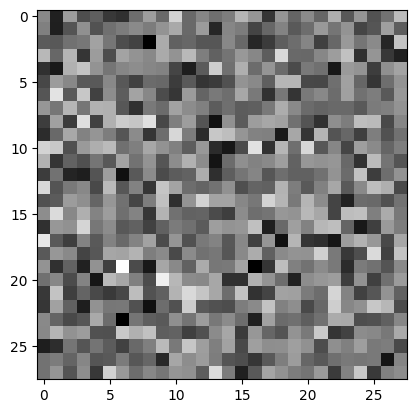

In [ ]:
# generator = load_model('generator_model.h5') # load model
vector = np.random.randn(100)
vector = vector.reshape(1, 100)
X = generator.predict(vector)
plt.imshow(X[0, :, :, 0], cmap="gray_r")
plt.show()

1/1 [==============================] - 0s 19ms/step


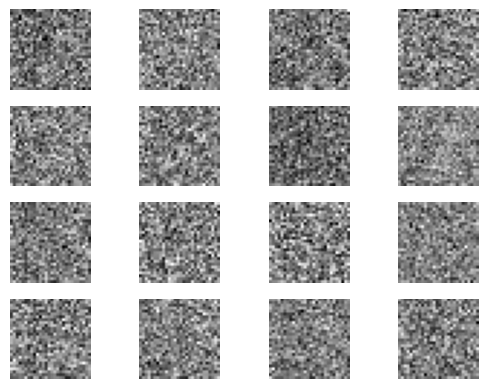

In [ ]:
def generate_latent_points(latent_dim, n_samples): # generate points in latent space
	x_input = np.random.randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

def save_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis("off")
		plt.imshow(examples[i, :, :, 0], cmap="gray_r")
	plt.show()

# generator = load_model("generator_model.h5")
latent_points = generate_latent_points(100, 16)
X = generator.predict(latent_points)
save_plot(X, 4)

# GAN Model Cifar Data

In [ ]:
def define_discriminator(in_shape=(32, 32, 3)):
  opt = Adam(lr=0.0002, beta_1=0.5)
  model = Sequential()
  model.add(Conv2D(128, (3,3), strides=(2,2), padding="same", input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128, (3,3), strides=(2,2), padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation="sigmoid"))
  model.compile(loss="binary_crossentropy", optimizer=opt,
                metrics=["accuracy"])
  model.summary()
  return model

def define_generator(latent_dim):
  n_nodes = 128 * 8 * 8
  model = Sequential()
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((8, 8, 128)))
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(3, (8,8), activation="tanh", padding="same"))
  model.summary()
  return model

def define_gan(generator, discriminator):
  discriminator.trainable = False
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss="binary_crossentropy", optimizer=opt)
  return model

def load_real_data():
  (X_train, _), (_, _) = cifar10.load_data()
  X = (X_train.astype(np.float32) - 127.5) / 127.5
  return X

def gen_real_samples(dataset, n_samples):
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = np.ones((n_samples, 1))
  return X, y

def gen_latent_points(latent_dim, n_samples):
  x_input = np.random.randn(latent_dim * n_samples)
  return x_input.reshape(n_samples, latent_dim)

def gen_fake_samples(generator, latent_dim, n_samples):
  X_input = gen_latent_points(latent_dim, n_samples)
  X = generator.predict(X_input)
  y = np.zeros((n_samples, 1))
  return X, y

def train_data(gen_model, discr_model, gan_model, dataset,
               latent_dim, n_epochs=100, n_batch=32):
  batch_per_epoch = int(dataset.shape[0]/ n_batch)
  half_batch = int(n_batch/2)
  for i in range(n_epochs):
    for j in range(batch_per_epoch):
      X_real, y_real = gen_real_samples(dataset, half_batch)
      X_fake, y_fake = gen_fake_samples(gen_model, latent_dim, half_batch)
      X_gan = gen_latent_points(latent_dim, n_batch)
      y_gan = np.ones((n_batch, 1))
      descr_loss_real, _ = discr_model.train_on_batch(X_real, y_real)
      descr_loss_fake, _ = discr_model.train_on_batch(X_fake, y_fake)
      gen_loss = gan_model.train_on_batch(X_gan, y_gan)
      print("Epoch>%d, Batch %d%d, d1=%.3f, d2=%.3f g=%.3f" %
       (i+1, j+1, batch_per_epoch, descr_loss_real, descr_loss_fake, gen_loss))
  # gen_model.save('cifar_generator_2epochs.h5')

In [ ]:
clear_session() # clear session
latent_dim = 100
discr = define_discriminator()
gener = define_generator(latent_dim)
gan_model = define_gan(gener, discr)
dataset = load_real_data()
train_data(gener, discr, gan_model, dataset, latent_dim, 1, 1000)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1)                 8

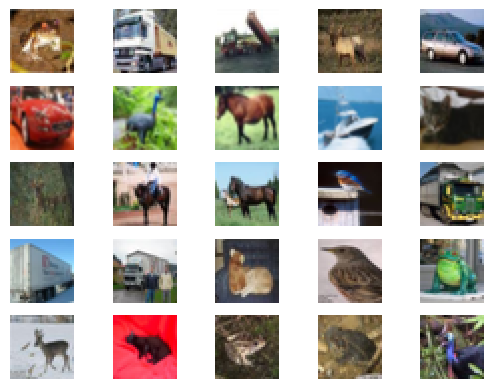

In [ ]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
for i in range(25):
  plt.subplot(5, 5, 1+i)
  plt.axis("off")
  plt.imshow(X_train[i])
plt.show()

1/1 [==============================] - 0s 29ms/step


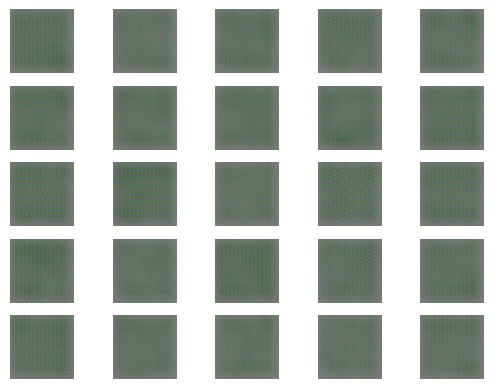

In [ ]:
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis("off")
		plt.imshow(examples[i, :, :, :])
	plt.show()
# gener = load_model('gen.h5')
latent_points = generate_latent_points(100, 25)  # latent dim and n_samples
X = gener.predict(latent_points)
X = (X + 1) / 2.0 # scale from [-1,1] to [0,1]
X = (X*255).astype(np.uint8)
show_plot(X, 5)

# Conditional GAN Model Cifar Data

In [ ]:
# funcs
def define_discriminator(in_shape=(32, 32, 3), n_classes=10):
  opt = Adam(lr=0.0002, beta_1=0.5)
  n_nodes = in_shape[0] * in_shape[1]
  input_label = Input(shape=(1,))
  cl_labels = Embedding(n_classes, 50)(input_label)
  cl_labels = Dense(n_nodes)(cl_labels)
  cl_labels = Reshape((in_shape[0], in_shape[1], 1))(cl_labels)
  input_image = Input(shape=in_shape)
  merged_inputs = Concatenate()([input_image, cl_labels]) # four channels, three for the image and one for the label
  X = Conv2D(128, (3,3), strides=(2,2), padding="same")(merged_inputs)
  X = LeakyReLU(alpha=0.2)(X)
  X = Conv2D(128, (3,3), strides=(2,2), padding="same")(X)
  X = LeakyReLU(alpha=0.2)(X)
  X = Flatten()(X)
  X = Dropout(0.4)(X)
  out_layer = Dense(1, activation="sigmoid")(X)
  model = Model([input_image, input_label], out_layer)
  model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
  model.summary()
  return model

def define_generator(latent_dim, n_classes=10):
  n_nodes = 8 * 8
  input_label = Input(shape=(1,))
  labels = Embedding(n_classes, 50)(input_label)
  labels = Dense(n_nodes)(input_label)
  labels = Reshape((8, 8, 1))(labels)
  input_latent = Input(shape=(latent_dim,))
  n_nodes = 128 * 8 * 8
  noise = Dense(n_nodes)(input_latent)
  noise = LeakyReLU(alpha=0.2)(noise)
  noise = Reshape((8, 8, 128))(noise)
  merged_inputs = Concatenate()([noise, labels])
  noise = Conv2DTranspose(128, (4,4), strides=(2,2), padding="same")(merged_inputs)
  noise = LeakyReLU(alpha=0.2)(noise)
  noise = Conv2DTranspose(128, (4,4), strides=(2,2), padding="same")(noise)
  noise = LeakyReLU(alpha=0.2)(noise)
  out_layer = Conv2D(3, (8,8), activation="tanh", padding="same")(noise)
  model = Model([input_latent, input_label], out_layer)
  model.summary()
  return model

def define_gan(generator, discriminator):
  discriminator.trainable = False
  gen_noise, gen_label = generator.input
  gen_output = generator.output
  gan_output = discriminator([gen_output, gen_label])
  model = Model([gen_noise, gen_label], gan_output)
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss="binary_crossentropy", optimizer=opt)
  return model

def load_real_data():
  (X_train, y_train), (_, _) = cifar10.load_data()
  X = (X_train.astype(np.float32) - 127.5) / 127.5
  return [X, y_train]

def gen_real_samples(dataset, n_samples):
  images, labels = dataset
  ix = np.random.randint(0, images.shape[0], n_samples)
  X, labels = images[ix], labels[ix]
  y = np.ones((n_samples, 1))
  return [X, labels], y

def gen_latent_points(latent_dim, n_samples, n_classes=10):
  x_input = np.random.randn(latent_dim * n_samples)
  z_input = x_input.reshape(n_samples, latent_dim)
  labels = np.random.randint(0, n_classes, n_samples)
  return [z_input, labels]

def gen_fake_samples(generator, latent_dim, n_samples):
  z_input, labels_input = gen_latent_points(latent_dim, n_samples)
  images = generator.predict([z_input, labels_input])
  y = np.zeros((n_samples, 1))
  return [images, labels_input], y

def train_data(gen_model, discr_model, gan_model, dataset, latent_dim,
               n_epochs=100, n_batch=128):
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      [X_real, labels_real], y_real = gen_real_samples(dataset, half_batch)
      discr_loss_real, _ = discr_model.train_on_batch([X_real, labels_real], y_real)
      [X_fake, labels], y_fake = gen_fake_samples(gen_model, latent_dim, half_batch)
      discr_loss_fake, _ = discr_model.train_on_batch([X_fake, labels], y_fake)
      [z_input, labels_input] = gen_latent_points(latent_dim, n_batch)
      y_gan = np.ones((n_batch, 1))
      gen_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
      print("Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f" % (i+1, j+1, bat_per_epo, discr_loss_real, discr_loss_fake, gen_loss))
# g_model.save('cifar_conditional_generator.h5')

In [ ]:
# train
clear_session() # clear session
latent_dim = 100
discr = define_discriminator()
gener = define_generator(latent_dim)
gan_model = define_gan(gener, discr)
dataset = load_real_data()
train_data(gener, discr, gan_model, dataset, latent_dim, 1, 128)

In [ ]:
# data
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
for i in range(25):
  plt.subplot(5, 5, 1+i)
  plt.axis("off")
  plt.imshow(X_train[i])
plt.show()

In [ ]:
# pred
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis("off")
		plt.imshow(examples[i, :, :, :])
	plt.show()
# gener = load_model('gen.h5')
latent_points = gen_latent_points(100, 25)
X = gener.predict(latent_points)
X = (X + 1) / 2.0 # scale from [-1,1] to [0,1]
X = (X*255).astype(np.uint8)
show_plot(X, 5)

# Pix2Pix GAN Model Map Images

## Model Architecture

In [ ]:
# funcs
clear_session() # clear session
def define_discriminator(image_shape):
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  init = RandomNormal(stddev=0.02)
  in_src_image = Input(shape=image_shape)
  in_target_image = Input(shape=image_shape)
  merged_inputs = Concatenate()([in_src_image, in_target_image])
  X = Conv2D(64, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(merged_inputs)
  X = LeakyReLU(alpha=0.2)(X)
  X = Conv2D(128, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(X)
  X = BatchNormalization()(X)
  X = LeakyReLU(alpha=0.2)(X)
  X = Conv2D(256, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(X)
  X = BatchNormalization()(X)
  X = LeakyReLU(alpha=0.2)(X)
  X = Conv2D(512, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(X)
  X = BatchNormalization()(X)
  X = LeakyReLU(alpha=0.2)(X)
  X = Conv2D(512, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(X)
  X = BatchNormalization()(X)
  X = LeakyReLU(alpha=0.2)(X)
  X = Conv2D(1, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(X)
  patch_out = Activation("sigmoid")(X)
  model = Model([in_src_image, in_target_image], patch_out)
  model.compile(loss="binary_crossentropy", optimizer=opt, loss_weights=[0.5])
  model.summary()
  return model

def encoder_block(layer_in, n_filters, batchnorm=True) :
  init = RandomNormal(stddev=0.02)
  enc = Conv2D(n_filters, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(layer_in)
  if batchnorm:
    enc = BatchNormalization()(enc, training=True)
  enc = LeakyReLU(alpha=0.2)(enc)
  return enc

def decoder_block(layer_in, skip_in, n_filters, dropout=True) :
  init = RandomNormal(stddev=0.02)
  dec = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(layer_in)
  dec = BatchNormalization()(dec, training=True)
  if dropout:
    dec = Dropout(0.5)(dec, training=True)
  dec = Concatenate()([dec, skip_in])
  dec = Activation("relu")(dec)
  return dec

def define_generator(image_shape=(256,256,3)):
  init = RandomNormal(stddev=0.02)
  in_image = Input(shape=image_shape)
  enc_block_1 = encoder_block(in_image, 64, batchnorm=False)
  enc_block_2 = encoder_block(enc_block_1, 128)
  enc_block_3 = encoder_block(enc_block_2, 256)
  enc_block_4 = encoder_block(enc_block_3, 512)
  enc_block_5 = encoder_block(enc_block_4, 512)
  enc_block_6 = encoder_block(enc_block_5, 512)
  enc_block_7 = encoder_block(enc_block_6, 512)
  bottleneck = Conv2D(512, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(enc_block_7)
  bottleneck = Activation("relu")(bottleneck)
  dec_block_1 = decoder_block(bottleneck, enc_block_7, 512)
  dec_block_2 = decoder_block(dec_block_1, enc_block_6, 512)
  dec_block_3 = decoder_block(dec_block_2, enc_block_5, 512)
  dec_block_4 = decoder_block(dec_block_3, enc_block_4, 512, dropout=False)
  dec_block_5 = decoder_block(dec_block_4, enc_block_3, 256, dropout=False)
  dec_block_6 = decoder_block(dec_block_5, enc_block_2, 128, dropout=False)
  dec_block_7 = decoder_block(dec_block_6, enc_block_1, 64, dropout=False)
  gen = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding="same", kernel_initializer=init)(dec_block_7)
  out_img = Activation("tanh")(gen)
  model = Model(in_image, out_img)
  model.summary()
  return model

def define_gan(gen, disc, image_shape):
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  for layer in disc.layers:
    if not isinstance(layer, BatchNormalization):
      layer.trainable = False
  in_src = Input(shape=image_shape)
  gen_out = gen(in_src)
  disc_out = disc([in_src, gen_out])
  model = Model(in_src, [disc_out, gen_out])
  model.compile(loss=["binary_crossentropy", "mae"], optimizer=opt, loss_weights=[1,100])
  model.summary()
  return model

def gen_real_samples(dataset, n_samples, patch_shape):
	trainA, trainB = dataset
	ix = np.random.randint(0, trainA.shape[0], n_samples)
	X1, X2 = trainA[ix], trainB[ix]
	y = np.ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

def gen_fake_samples(gen_model, samples, patch_shape):
	X = gen_model.predict(samples)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

def summarize_performance(step, gen_model, dataset, n_samples=3):
	[X_realA, X_realB], _ = gen_real_samples(dataset, n_samples, 1)
	X_fakeB, _ = gen_fake_samples(gen_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	for i in range(n_samples):	# plot real source images
		plt.subplot(3, n_samples, 1 + i)
		plt.axis("off")
		plt.imshow(X_realA[i])
	for i in range(n_samples):	# plot generated target image
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis("off")
		plt.imshow(X_fakeB[i])
	for i in range(n_samples):	# plot real target image
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis("off")
		plt.imshow(X_realB[i])
	filename = "plot_%06d.png" % (step+1)
	plt.savefig(filename)
	plt.close()
	fname = "model_%06d.h5" % (step+1)
	gen_model.save(fname)
	print(">> Saved: %s and %s" % (filename, fname))

def train(disc_model, gen_model, gan_model, dataset, n_epochs=100, n_batch=1): # train pix2pix models
	n_patch = disc_model.output_shape[1]
	trainA, trainB = dataset
	bat_per_epo = int(len(trainA) / n_batch)
	n_steps = bat_per_epo * n_epochs
	for i in range(n_steps):
		[X_realA, X_realB], y_real = gen_real_samples(dataset, n_batch, n_patch)
		X_fakeB, y_fake = gen_fake_samples(gen_model, X_realA, n_patch)
		disc_loss_one = disc_model.train_on_batch([X_realA, X_realB], y_real)
		disc_loss_two = disc_model.train_on_batch([X_realA, X_fakeB], y_fake)
		gen_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		print(">> %d, d1[%.3f] d2[%.3f] g[%.3f]" % (i+1, disc_loss_one, disc_loss_two, gen_loss))
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, gen_model, dataset)

## Train Model  

In [ ]:
# Datasets here: http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/
def load_images(path, size=(256,512)): # load all images in a directory into memory
	src_list, tar_list = list(), list()
	for filename in os.listdir(path):
		pixels = load_img(path + filename, target_size=size)
		pixels = img_to_array(pixels)
		sat_img, map_img = pixels[:, :256], pixels[:, 256:] # split into satellite and map
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [np.asarray(src_list), np.asarray(tar_list)]

def preprocess_data(data):
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

path = "maps/train/"
[src_images, tar_images] = load_images(path)
print("Loaded: ", src_images.shape, tar_images.shape)

n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis("off")
	plt.imshow(src_images[i].astype("uint8"))

for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis("off")
	plt.imshow(tar_images[i].astype("uint8"))
plt.show()

image_shape = src_images.shape[1:]
disc_model = define_discriminator(image_shape)
gen_model = define_generator(image_shape)
gan_model = define_gan(gen_model, disc_model, image_shape)
data = [src_images, tar_images]
dataset = preprocess_data(data)

start_train = datetime.now()
train(disc_model, gen_model, gan_model, dataset, n_epochs=1, n_batch=1)
stop_train = datetime.now()
exe_time = stop_train-start_train
print("Execution time is: ", exe_time)

In [ ]:
# generate outputs
# gen_model = load_model('gen_model.h5')
def plot_images(src_img, gen_img, tar_img):
	images = np.vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ["Source", "Generated", "Expected"]
	for i in range(len(images)):
		plt.subplot(1, 3, 1 + i)
		plt.axis("off")
		plt.imshow(images[i])
		plt.title(titles[i])
	plt.show()
[X1, X2] = dataset
ix = np.randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
gen_image = gen_model.predict(src_image)
plot_images(src_image, gen_image, tar_image)

# Pix2Pix GAN Model Tomography Scan

In [ ]:
# funcs
clear_session() # clear session
def define_discriminator(image_shape):
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  init = RandomNormal(stddev=0.02)
  in_src_image = Input(shape=image_shape)
  in_target_image = Input(shape=image_shape)
  merged_inputs = Concatenate()([in_src_image, in_target_image])
  X = Conv2D(64, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(merged_inputs)
  X = LeakyReLU(alpha=0.2)(X)
  X = Conv2D(128, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(X)
  X = BatchNormalization()(X)
  X = LeakyReLU(alpha=0.2)(X)
  X = Conv2D(256, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(X)
  X = BatchNormalization()(X)
  X = LeakyReLU(alpha=0.2)(X)
  X = Conv2D(512, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(X)
  X = BatchNormalization()(X)
  X = LeakyReLU(alpha=0.2)(X)
  X = Conv2D(512, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(X)
  X = BatchNormalization()(X)
  X = LeakyReLU(alpha=0.2)(X)
  X = Conv2D(1, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(X)
  patch_out = Activation("sigmoid")(X)
  model = Model([in_src_image, in_target_image], patch_out)
  model.summary()
  model.compile(loss="binary_crossentropy", optimizer=opt, loss_weights=[0.5])
  return model

def encoder_block(layer_in, n_filters, batchnorm=True) :
  init = RandomNormal(stddev=0.02)
  enc = Conv2D(n_filters, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(layer_in)
  if batchnorm:
    enc = BatchNormalization()(enc, training=True)
  enc = LeakyReLU(alpha=0.2)(enc)
  return enc

def decoder_block(layer_in, skip_in, n_filters, dropout=True) :
  init = RandomNormal(stddev=0.02)
  dec = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(layer_in)
  dec = BatchNormalization()(dec, training=True)
  if dropout:
    dec = Dropout(0.5)(dec, training=True)
  dec = Concatenate()([dec, skip_in])
  dec = Activation("relu")(dec)
  return dec

def define_generator(image_shape=(256,256,3)):
  init = RandomNormal(stddev=0.02)
  in_image = Input(shape=image_shape)
  enc_block_1 = encoder_block(in_image, 64, batchnorm=False)
  enc_block_2 = encoder_block(enc_block_1, 128)
  enc_block_3 = encoder_block(enc_block_2, 256)
  enc_block_4 = encoder_block(enc_block_3, 512)
  enc_block_5 = encoder_block(enc_block_4, 512)
  enc_block_6 = encoder_block(enc_block_5, 512)
  enc_block_7 = encoder_block(enc_block_6, 512)
  bottleneck = Conv2D(512, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(enc_block_7)
  bottleneck = Activation("relu")(bottleneck)
  dec_block_1 = decoder_block(bottleneck, enc_block_7, 512)
  dec_block_2 = decoder_block(dec_block_1, enc_block_6, 512)
  dec_block_3 = decoder_block(dec_block_2, enc_block_5, 512)
  dec_block_4 = decoder_block(dec_block_3, enc_block_4, 512, dropout=False)
  dec_block_5 = decoder_block(dec_block_4, enc_block_3, 256, dropout=False)
  dec_block_6 = decoder_block(dec_block_5, enc_block_2, 128, dropout=False)
  dec_block_7 = decoder_block(dec_block_6, enc_block_1, 64, dropout=False)
  gen = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding="same", kernel_initializer=init)(dec_block_7)
  out_img = Activation("tanh")(gen)
  model = Model(in_image, out_img)
  model.summary()
  return model

def define_gan(gen, disc, image_shape):
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  for layer in disc.layers:
    if not isinstance(layer, BatchNormalization):
      layer.trainable = False
  in_src = Input(shape=image_shape)
  gen_out = gen(in_src)
  disc_out = disc([in_src, gen_out])
  model = Model(in_src, [disc_out, gen_out])
  model.compile(loss=["binary_crossentropy", "mae"], optimizer=opt, loss_weights=[1,100])
  return model

def gen_real_samples(dataset, n_samples, patch_shape):
	trainA, trainB = dataset
	ix = np.random.randint(0, trainA.shape[0], n_samples)
	X1, X2 = trainA[ix], trainB[ix]
	y = np.ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

def gen_fake_samples(gen_model, samples, patch_shape):
	X = gen_model.predict(samples)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

def summarize_performance(step, gen_model, dataset, n_samples=3):
	[X_realA, X_realB], _ = gen_real_samples(dataset, n_samples, 1)
	X_fakeB, _ = gen_fake_samples(gen_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	for i in range(n_samples):	# plot real source images
		plt.subplot(3, n_samples, 1 + i)
		plt.axis("off")
		plt.imshow(X_realA[i])
	for i in range(n_samples):	# plot generated target image
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis("off")
		plt.imshow(X_fakeB[i])
	for i in range(n_samples):	# plot real target image
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis("off")
		plt.imshow(X_realB[i])
	filename1 = "plot_%06d.png" % (step+1)
	plt.savefig(filename1) # save plot to file
	plt.close()
	filename2 = "model_%06d.h5" % (step+1)
	gen_model.save(filename2) # save the generator model
	print(">> Saved: %s and %s" % (filename1, filename2))

def preprocess_data(data):
	X1, X2 = data[0], data[1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# train pix2pix models
def train(disc_model, gen_model, gan_model, dataset, n_epochs=100, n_batch=1):
	n_patch = disc_model.output_shape[1]
	trainA, trainB = dataset
	bat_per_epo = int(len(trainA) / n_batch)
	n_steps = bat_per_epo * n_epochs
	for i in range(n_steps):
		[X_realA, X_realB], y_real = gen_real_samples(dataset, n_batch, n_patch)
		X_fakeB, y_fake = gen_fake_samples(gen_model, X_realA, n_patch)
		disc_loss_one = disc_model.train_on_batch([X_realA, X_realB], y_real)
		disc_loss_two = disc_model.train_on_batch([X_realA, X_fakeB], y_fake)
		gen_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		print(">> %d, d1[%.3f] d2[%.3f] g[%.3f]" % (i+1, disc_loss_one, disc_loss_two, gen_loss))
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, gen_model, dataset)

In [ ]:
# Dataset link: https://drive.google.com/file/d/1HWtBaSa-LTyAMgf2uaz1T9o1sTWDBajU/view
SIZE_X = 256
SIZE_Y = 256
tar_images = []
for directory_path in glob.glob("sandstone/images/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        img = cv2.imread(img_path, 1)
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        tar_images.append(img)
tar_images = np.array(tar_images)
src_images = []
for directory_path in glob.glob("sandstone/masks/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tif")):
        mask = cv2.imread(mask_path, 1)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
        src_images.append(mask)
src_images = np.array(src_images)
print(np.unique(src_images))
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis("off")
	plt.imshow(src_images[i])
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis("off")
	plt.imshow(tar_images[i])
plt.show()
image_shape = src_images.shape[1:]
disc_model = define_discriminator(image_shape)
gen_model = define_generator(image_shape)
gan_model = define_gan(gen_model, disc_model, image_shape)
data = [src_images, tar_images]
dataset = preprocess_data(data)
start = datetime.now()
train(disc_model, gen_model, gan_model, dataset, n_epochs=50, n_batch=1)
stop = datetime.now()
execution_time = stop-start
print("Execution time is: ", execution_time)
gen_model.save("sandstone.h5")

In [ ]:
model = load_model("sandstone.h5")
def plot_images(src_img, gen_img, tar_img):
	images = np.vstack((src_img, gen_img, tar_img))
	images = (images + 1) / 2.0
	titles = ["Input-segm-img", "Output-Generated", "Original"]
	for i in range(len(images)):
		plt.subplot(1, 3, 1 + i)
		plt.axis("off")
		plt.imshow(images[i,:,:,0], cmap="gray")
		plt.title(titles[i])
	plt.show()
[X1, X2] = dataset
ix = np.random.randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
gen_image = model.predict(src_image)
plot_images(src_image, gen_image, tar_image)
test_src_img = cv2.imread("sandstone/test_mask.tif", 1)
test_src_img = cv2.resize(test_src_img, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
test_src_img = (test_src_img - 127.5) / 127.5
test_src_img = np.expand_dims(test_src_img, axis=0)
gen_test_image = model.predict(test_src_img)
plt.imshow(gen_test_image[0, :,:,0], cmap="gray")

# CycleGAN Model Monet To Photo

## InstanceNormalization

Source: https://github.com/keras-team/keras-contrib

In [ ]:
from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints
from keras import backend as K


class InstanceNormalization(Layer):
    """Instance normalization layer.

    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.

    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.

    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.

    # Output shape
        Same shape as input.

    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Model Architecture

In [ ]:
def define_disc(image_shape):
	init = RandomNormal(stddev=0.02)
	in_image = Input(shape=image_shape)
	disc = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	disc = LeakyReLU(alpha=0.2)(disc)
	disc = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(disc)
	disc = InstanceNormalization(axis=-1)(disc)
	disc = LeakyReLU(alpha=0.2)(disc)
	disc = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(disc)
	disc = InstanceNormalization(axis=-1)(disc)
	disc = LeakyReLU(alpha=0.2)(disc)
	disc = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(disc)
	disc = InstanceNormalization(axis=-1)(disc)
	disc = LeakyReLU(alpha=0.2)(disc)
	disc = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(disc)
	disc = InstanceNormalization(axis=-1)(disc)
	disc = LeakyReLU(alpha=0.2)(disc)
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(disc)
	model = Model(in_image, patch_out)
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

def resnet_block(n_filters, input_layer):
	init = RandomNormal(stddev=0.02)
	gen = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	gen = InstanceNormalization(axis=-1)(gen)
	gen = Activation('relu')(gen)
	gen = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(gen)
	gen = InstanceNormalization(axis=-1)(gen)
	gen = Concatenate()([gen, input_layer])
	return gen

def define_gen(image_shape, n_resnet=9):
	init = RandomNormal(stddev=0.02)
	in_image = Input(shape=image_shape)
	gen = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	gen = InstanceNormalization(axis=-1)(gen)
	gen = Activation('relu')(gen)
	gen = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = InstanceNormalization(axis=-1)(gen)
	gen = Activation('relu')(gen)
	gen = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = InstanceNormalization(axis=-1)(gen)
	gen = Activation('relu')(gen)
	for _ in range(n_resnet):
		gen = resnet_block(256, gen)
	gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = InstanceNormalization(axis=-1)(gen)
	gen = Activation('relu')(gen)
	gen = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = InstanceNormalization(axis=-1)(gen)
	gen = Activation('relu')(gen)
	gen = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(gen)
	gen = InstanceNormalization(axis=-1)(gen)
	out_image = Activation('tanh')(gen)
	model = Model(in_image, out_image)
	return model

def define_gan(gen_model_one, disc_model, gen_model_two, image_shape):
	gen_model_one.trainable = True
	disc_model.trainable = False
	gen_model_two.trainable = False
	input_gen = Input(shape=image_shape)
	gen_one_out = gen_model_one(input_gen)
	output_disc = disc_model(gen_one_out)
	input_id = Input(shape=image_shape)
	output_id = gen_model_one(input_id)
	output_f = gen_model_two(gen_one_out)
	gen_two_out = gen_model_two(input_id)
	output_b = gen_model_one(output_b)
	model = Model([input_gen, input_id], [output_disc, output_id, output_f, output_b])
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['mse', 'mae', 'mae', 'mae'],
               loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

def load_real_samples(filename):
	data = np.load(filename)
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

def generate_real_samples(dataset, n_samples, patch_shape):
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = np.ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

def generate_fake_samples(gen_model, dataset, patch_shape):
	X = gen_model.predict(dataset)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# periodically save the generator models to file
def save_models(step, gen_model_AtoB, gen_model_BtoA):
  fname_one = 'g_model_AtoB_%06d.h5' % (step+1) # save the first generator model
  fname_two = 'g_model_BtoA_%06d.h5' % (step+1) # save the second generator model
  gen_model_AtoB.save(fname_one)
  gen_model_BtoA.save(fname_two)
  print('>Saved: %s and %s' % (fname_one, fname_two))

# periodically generate images using the save model and plot input and output images
def summarize_performance(step, gen_model, trainX, name, n_samples=5):
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	X_out, _ = generate_fake_samples(gen_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	for i in range(n_samples):
		plt.subplot(2, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_in[i])
	for i in range(n_samples):
		plt.subplot(2, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_out[i])
	filename = '%s_generated_plot_%06d.png' % (name, (step+1))
	plt.savefig(filename)
	plt.close()

def update_image_pool(pool, images, max_size=50):
	selected_img = list()
	for image in images:
		if len(pool) < max_size:
			pool.append(image)
			selected_img.append(image)
		elif np.r_andom.random() < 0.5:
			selected_img.append(image)
		else:
			ix = np.random.randint(0, len(pool))
			selected_img.append(pool[ix])
			pool[ix] = image
	return np.asarray(selected_img)

def train(disc_model_A, disc_model_B, gen_model_AtoB, gen_model_BtoA, gan_model_AtoB, gan_model_BtoA, dataset, epochs=1):
	n_epochs, n_batch, = epochs, 1
	n_patch = disc_model_A.output_shape[1]
	trainA, trainB = dataset
	poolA, poolB = list(), list()
	bat_per_epo = int(len(trainA) / n_batch)
	n_steps = bat_per_epo * n_epochs
	for i in range(n_steps):
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		X_fakeA, y_fakeA = generate_fake_samples(gen_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(gen_model_AtoB, X_realA, n_patch)
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		gen_loss_BtoA, _, _, _, _  = gan_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		disc_loss_A_one = disc_model_A.train_on_batch(X_realA, y_realA)
		disc_loss_A_two = disc_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via the composite model
		gen_loss_AtoB, _, _, _, _ = gan_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		disc_loss_B_one = disc_model_B.train_on_batch(X_realB, y_realB)
		disc_loss_B_two = disc_model_B.train_on_batch(X_fakeB, y_fakeB)
    # summarize performance
    # since the batch size =1, the number of iterations would be same as the size of our dataset
    # in one epoch iterations equal to the number of images
    # if you have 100 images then 1 epoch would be 100 iterations
		print('Iteration > %d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, disc_loss_A_one, disc_loss_A_two,
                                                                    disc_loss_B_one, disc_loss_B_two, gen_loss_AtoB, gen_loss_BtoA))
		# evaluate the model performance periodically
    # If batch size (total images)=100, performance will be summarized after every 75th iteration
		if (i+1) % (bat_per_epo * 1) == 0:
			summarize_performance(i, gen_model_AtoB, trainA, 'AtoB')
			summarize_performance(i, gen_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 5) == 0:
			# save the models
      # if batch size (total images)=100, model will be saved after
      # every 75th iteration x 5 = 375 iterations
			save_models(i, gen_model_AtoB, gen_model_BtoA)

## Train Model

Dataset from https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/

In [ ]:
def load_images(path, size=(256,256)):
	data_list = list()
	for filename in os.listdir(path):
		pixels = load_img(path + filename, target_size=size)
		pixels = img_to_array(pixels)
		data_list.append(pixels)
	return np.asarray(data_list)

path = 'monet2photo/'
dataA_all = load_images(path + 'trainA/')
print('Loaded dataA: ', dataA_all.shape)
dataA = resample(dataA_all,
                 replace=False,
                 n_samples=500,
                 random_state=42)
dataB_all = load_images(path + 'trainB/')
print('Loaded dataB: ', dataB_all.shape)
dataB = resample(dataB_all,
                 replace=False,
                 n_samples=500,
                 random_state=42)
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(dataA[i].astype('uint8'))

for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(dataB[i].astype('uint8'))
plt.show()

data = [dataA, dataB]

print('Loaded', data[0].shape, data[1].shape)

# preprocess data to change input range to values between -1 and 1
# this is because the generator uses tanh activation in the output layer
# and tanh ranges between -1 and 1

def preprocess_data(data):
	X1, X2 = data[0], data[1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_gan(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_gan(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

start = datetime.now()
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=5)
stop = datetime.now()
execution_time = stop - start
print("Execution time is: ", execution_time)

def select_sample(dataset, n_samples):
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	return X

def show_plot(imagesX, imagesY1, imagesY2):
	images = np.vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	images = (images + 1) / 2.0
	for i in range(len(images)):
		plt.subplot(1, len(images), 1 + i)
		plt.axis('off')
		plt.imshow(images[i])
		plt.title(titles[i])
	plt.show()

A_data = resample(dataA_all,
                 replace=False,
                 n_samples=50,
                 random_state=42)

B_data = resample(dataB_all,
                 replace=False,
                 n_samples=50,
                 random_state=42)

A_data = (A_data - 127.5) / 127.5
B_data = (B_data - 127.5) / 127.5

cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('monet2photo_models/g_model_AtoB.h5', cust)
model_BtoA = load_model('monet2photo_models/g_model_BtoA.h5', cust)

# plot A->B->A (Monet to photo to Monet)
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)
# plot B->A->B (Photo to Monet to Photo)
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

test_image = load_img('monet2photo/sunset.jpg')
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
monet_generated  = model_BtoA.predict(test_image_input)
photo_reconstructed = model_AtoB.predict(monet_generated)
show_plot(test_image_input, monet_generated, photo_reconstructed)

# SRGAN Model Super Resolution

## Preprocess Images

Dataset from: http://press.liacs.nl/mirflickr/mirdownload.html

In [ ]:
# HR images: 128x128
# LR images: 32x32
train_dir = "data"
for img in os.listdir( train_dir + "/original_images"):
    img_array = cv2.imread(train_dir + "/original_images/" + img)
    img_array = cv2.resize(img_array, (128,128))
    lr_img_array = cv2.resize(img_array,(32,32))
    cv2.imwrite(train_dir+ "/hr_images/" + img, img_array)
    cv2.imwrite(train_dir+ "/lr_images/"+ img, lr_img_array)

## Model Architecture

Dataset from: http://press.liacs.nl/mirflickr/mirdownload.html

In [ ]:
def res_block(ip):
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    return add([ip,res_model])

def upscale_block(ip):
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    return up_model

def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)
    temp = layers
    for i in range(num_res_block):
        layers = res_block(layers)
    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])
    layers = upscale_block(layers)
    layers = upscale_block(layers)
    op = Conv2D(3, (9,9), padding="same")(layers)
    return Model(inputs=gen_ip, outputs=op)

def discriminator_block(ip, filters, strides=1, bn=True):
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    return disc_model

def create_disc(disc_ip):
    df = 64
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation="sigmoid")(d10)
    return Model(disc_ip, validity)

# VGG19:
# needs VGG19 for the feature map obtained by the j-th convolution (after activation)
# before the i-th maxpooling layer within the VGG19 network as described in the paper
# let's pick the 3rd block, last conv layer.
# build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# vgg architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
def build_vgg(hr_shape):
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    gen_features = vgg(gen_img)
    disc_model.trainable = False
    validity = disc_model(gen_img)
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

# two losses: adversarial loss and content (VGG) loss
# adversariaL is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

# content: feature map obtained by the j-th convolution (after activation)
# before the i-th maxpooling layer within the VGG19 network.
# mse between the feature representations of a reconstructed image
# and the reference image.

n = 5000
lr_list = os.listdir("data/lr_images")[:n]
lr_images = []
for img in lr_list:
    img_lr = cv2.imread("data/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)

hr_list = os.listdir("data/hr_images")[:n]
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("data/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)
image_number = np.random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()
lr_images = lr_images / 255.
hr_images = hr_images / 255.
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, test_size=0.33, random_state=42)
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])
lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)
generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam",
                      metrics=["accuracy"])
discriminator.summary()
vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

# create a list of images for LR and HR in batches from which a batch of images
# would be fetched during training.
batch_size = 1
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

epochs = 5
for e in range(epochs):
    fake_label = np.zeros((batch_size, 1)) # assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # assign a label of 1 to all real images.
    # create empty lists to populate gen and disc losses.
    g_losses = []
    d_losses = []
    # enumerate training over batches.
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] # fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] # fetch a batch of HR images for training
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        # first, train the discriminator on fake and real HR images.
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        # train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        # average the discriminator loss, just for reporting purposes.
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)
        # extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        # save losses to a list so we can average and report.
        d_losses.append(d_loss)
        g_losses.append(g_loss)
    # convert the list of losses to an array to make it easy to average
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    # calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    # report the progress during training.
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: # change the frequency for model saving, if needed
        # save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")

## Test Model

In [ ]:
generator = load_model("gen.h5", compile=False)

[X1, X2] = [lr_test, hr_test]
ix = np.random.randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
gen_image = generator.predict(src_image)
# plot
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title("LR Image")
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title("Superresolution")
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title("Orig. HR Image")
plt.imshow(tar_image[0,:,:,:])
plt.show()
#
pic_lr = cv2.imread("data/pic_32.jpg")
pic_hr = cv2.imread("data/pic_256.jpg")
pic_lr = cv2.cvtColor(pic_lr, cv2.COLOR_BGR2RGB)
pic_hr = cv2.cvtColor(pic_hr, cv2.COLOR_BGR2RGB)
pic_lr = pic_lr / 255.
pic_hr = pic_hr / 255.
pic_lr = np.expand_dims(pic_lr, axis=0)
pic_hr = np.expand_dims(pic_hr, axis=0)
gen_pic_hr = generator.predict(pic_lr)
# plot
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title("LR Image")
plt.imshow(pic_lr[0,:,:,:])
plt.subplot(232)
plt.title("Superresolution")
plt.imshow(gen_pic_hr[0,:,:,:])
plt.subplot(233)
plt.title("Orig. HR Image")
plt.imshow(pic_hr[0,:,:,:])
plt.show()

# Wasserstein GAN

In [ ]:
def build_generator():
    noise_shape = (100,)
    model = Sequential(name="generator")
    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation="tanh"))
    model.add(Reshape(img_shape))
    model.summary()
    noise = Input(shape=noise_shape)
    fake_img = model(noise)
    return Model(noise, fake_img)

def build_discriminator():
    model = Sequential(name="discriminator")
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1))
    model.summary()
    img = Input(shape=img_shape)
    validity = model(img)
    return Model(img, validity) # the discriminator's output layer has no activation function.

def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true * y_pred)

def save_imgs(epoch):
  r, c = 5, 5
  noise = np.random.normal(0, 1, (r * c, 100))
  gen_imgs = generator.predict(noise)
  gen_imgs = 0.5 * gen_imgs + 0.5
  fig, axs = plt.subplots(r,c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      axs[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap="gray")
      axs[i,j].axis("off")
      cnt += 1
    # fig.savefig("Images/mnist_%d.png" % epoch)
    plt.close()

def train_data(epochs, batch_size=128, save_interval=500, clip_value=0.01):
    (X_train, _), (_, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    half_batch = int(batch_size/2)
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]
        noise = np.random.normal(0, 1, (half_batch, 100))
        gen_imgs = generator.predict(noise)
        loss_real_img = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        loss_fake_img = discriminator.train_on_batch(gen_imgs, -np.ones((half_batch, 1)))
        discrim_loss = 0.5 * np.add(loss_real_img, loss_fake_img)
        for layer in discriminator.layers: # the discriminator's weights are clipped to enforce the Lipschitz constraint
            weights = layer.get_weights()
            weights = [np.clip(w, -clip_value, clip_value) for w in weights]
            layer.set_weights(weights)
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))
        gen_loss = gan_model.train_on_batch(noise, valid_y)
        print("%d [D loss: %f] [G loss: %f]" % (epoch, -discrim_loss[0], gen_loss))
        if epoch % save_interval == 0:
            save_imgs(epoch)

In [ ]:
clear_session()  # clear session
img_rows, img_cols = 28, 28
num_channels = 1
img_shape = (img_rows, img_cols, num_channels)
optimizer = Adam(0.0002, 0.5)
discriminator = build_discriminator()
discriminator.compile(loss=wasserstein_loss, optimizer=optimizer, metrics=["accuracy"])
generator = build_generator()
generator.compile(loss=wasserstein_loss, optimizer=optimizer)
z = Input(shape=(100,))
img = generator(z)
discriminator.trainable = False
valid = discriminator(img)
gan_model = Model(z, valid, name="gan")
gan_model.compile(loss=wasserstein_loss, optimizer=optimizer)
gan_model.summary()
train_data(epochs=1, batch_size=32, save_interval=500, clip_value=0.01)

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533505 (2.04 MB)
Trainable params: 5335

0 [D loss: 0.819667] [G loss: 0.000586]
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 45ms/step


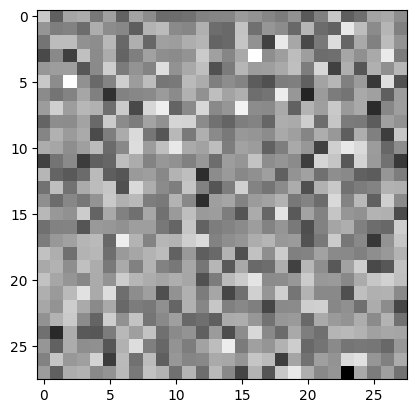

In [ ]:
# generator = load_model('generator_model.h5') # load model
vector = np.random.randn(100)
vector = vector.reshape(1, 100)
X = generator.predict(vector)
plt.imshow(X[0, :, :, 0], cmap="gray_r")
plt.show()

1/1 [==============================] - 0s 44ms/step


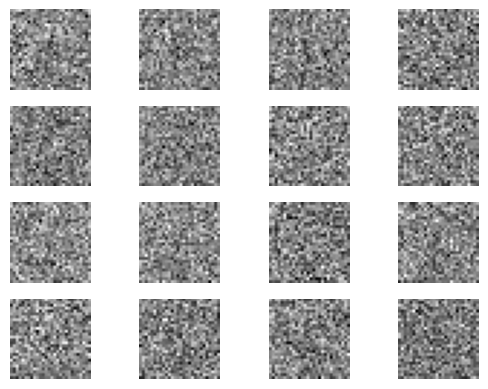

In [ ]:
def generate_latent_points(latent_dim, n_samples): # generate points in latent space
	x_input = np.random.randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

def save_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis("off")
		plt.imshow(examples[i, :, :, 0], cmap="gray_r")
	plt.show()

# generator = load_model("generator_model.h5")
latent_points = generate_latent_points(100, 16)
X = generator.predict(latent_points)
save_plot(X, 4)


# GAN Model Latent Space

## Extract Faces

Dataset: https://www.kaggle.com/jessicali9530/celeba-dataset

Haarcascade models: https://github.com/opencv/opencv/tree/master/data/haarcascades

In [ ]:
face_cascade = cv2.CascadeClassifier("haarcascades_models/haarcascade_frontalface_default.xml")
path = "data/*.*"
img_number = 1
for file in glob.glob(path):
    print(file)
    img= cv2.imread(file, 1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    try:
        for (x,y,w,h) in faces:
            roi_color = img[y:y+h, x:x+w]
        resized = cv2.resize(roi_color, (128,128))
        cv2.imwrite("faces/"+str(img_number)+".jpg", resized)
    except:
        print("No faces detected")
    img_number +=1

## Define Model

Dataset: https://susanqq.github.io/UTKFace/

### Model Archtecture

In [ ]:
# define the standalone discriminator model
# input would be 128x128x3 images and the output would be a binary (using sigmoid)
# discriminator is just a binary classifier for true/fake images
def define_discriminator(in_shape=(128,128,3)):
	model = Sequential()
	model.add(Conv2D(128, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) # downsample to 64x64
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) # downsample to 32x32
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) # downsample to 16x16
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) # downsample to 8x8
	model.add(LeakyReLU(alpha=0.2))
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid')) # classifier
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
test_discr = define_discriminator()
print(test_discr.summary())
plot_model(test_discr, to_file='disc_model.png', show_shapes=True)

# define the standalone generator model
# generator must generate 128x128x3 images that can be fed into the discriminator
# So, we start with enough nodes in the dense layer that can be gradually upscaled to 128x128x3.
# remember that the input would be a latent vector (usually size 100)
def define_generator(latent_dim):
	model = Sequential()
	n_nodes = 128 * 8 * 8 # define number of nodes that can be gradually reshaped and upscaled to 128x128x3
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # upsample to 16x16
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # upsample to 32x32
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # upsample to 64x64
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # upsample to 128x128
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) # output layer 128x128x3
  # note: tanh goes from [-1,1]
	return model
test_gen = define_generator(100)
print(test_gen.summary())
plot_model(test_gen, to_file='generator_model.png', show_shapes=True)

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	d_model.trainable = False
	model = Sequential()
	model.add(g_model)
	model.add(d_model)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
test_gan = define_gan(test_gen, test_discr)
print(test_gan.summary())
plot_model(test_gan, to_file='combined_model.png', show_shapes=True)

def generate_real_samples(dataset, n_samples):
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = np.ones((n_samples, 1))
	return X, y

def generate_latent_points(latent_dim, n_samples):
	x_input = np.randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim) # reshape to be provided as input to the generator.
	return x_input

def generate_fake_samples(g_model, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples) # generate latent points as input to the generator
	X = g_model.predict(x_input) # use the generator to generate fake images
	y = np.zeros((n_samples, 1)) # class labels for fake images are 0
	return X, y

def save_plot(examples, epoch, n=10):
	examples = (examples + 1) / 2.0 # scale images from [-1,1] to [0,1] so we can plot
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i])
	# save plot to a file so we can view how generated images evolved over epochs
	filename = 'saved_data_during_training/images/generated_plot_128x128_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

def summarize_performance(epoch, gen_model, disc_model, dataset, latent_dim, n_samples=100):
	X_real, y_real = generate_real_samples(dataset, n_samples)
	_, acc_real = disc_model.evaluate(X_real, y_real, verbose=0)
	x_fake, y_fake = generate_fake_samples(gen_model, latent_dim, n_samples)
	_, acc_fake = disc_model.evaluate(x_fake, y_fake, verbose=0)
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	save_plot(x_fake, epoch)
	filename = 'saved_data_during_training/models/generator_model_128x128_%03d.h5' % (epoch+1)
	gen_model.save(filename)

def train(gen_model, disc_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2) # disc. trained on half batch real and half batch fake images
	for i in range(n_epochs):
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(dataset, half_batch) # fetch random 'real' images
			disc_loss_one, _ = disc_model.train_on_batch(X_real, y_real) # train the disc using real images
			X_fake, y_fake = generate_fake_samples(gen_model, latent_dim, half_batch) # generate 'fake' images
			disc_loss_two, _ = disc_model.train_on_batch(X_fake, y_fake) # train the disc using fake images
			X_gan = generate_latent_points(latent_dim, n_batch) # generate latent vectors as input for the generator
			y_gan = np.ones((n_batch, 1)) # label generated (fake) mages as 1 to fool the discriminator
			gen_loss = gan_model.train_on_batch(X_gan, y_gan) # train the generator (via the discriminator's error)
			print('Epoch>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, disc_loss_one, disc_loss_two, gen_loss)) # report disc and gen losses
		if (i+1) % 10 == 0:
			summarize_performance(i, gen_model, disc_model, dataset, latent_dim) # evaluate the model performance

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 128)     3584      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 128, 128, 128)     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 128)      

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 128, 128, 3)       1901059   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 602113    
                                                                 
Total params: 2503172 (9.55 MB)
Trainable params: 1901059 (7.25 MB)
Non-trainable params: 602113 (2.30 MB)
_________________________________________________________________
None


### Train Model

In [ ]:
n = 20000 # number of images to read from the directory for training
SIZE = 128 # resize images to this size
all_img_list = os.listdir("data/UTKFace/UTKFace/")
dataset_list = np.random.sample(all_img_list, n) # get n random images from the directory
# read images, resize and capture into a numpy array
dataset = []
for img in dataset_list:
    temp_img = cv2.imread("data/UTKFace/UTKFace/" + img)
    temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB) # opencv reads images as BGR so let us convert back to RGB
    temp_img = Image.fromarray(temp_img)
    temp_img = temp_img.resize((SIZE, SIZE)) # resize
    dataset.append(np.array(temp_img))
dataset = np.array(dataset) # vonvert the list to numpy array
dataset = dataset.astype("float32")
dataset = (dataset - 127.5) / 127.5 # scale from [0,255] to [-1,1] - remember that the generator uses tanh activation that goes from -1,1
latent_dim = 100
disc_model = define_discriminator()
gen_model = define_generator(latent_dim)
gan_model = define_gan(gen_model, disc_model)
train(gen_model, disc_model, gan_model, dataset, latent_dim, n_epochs=100)

### Explore Latent Space

In [ ]:
def plot_img(examples, n): # plot of generated images
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis("off")
		plt.imshow(examples[i, :, :])
	plt.show()

# generate two latent vectors and interpolate between them.
# use linear interpolation although in reality the latent space is curved.
# interpolating between faces - Linear interpolation

def interpolate_points(p1, p2, n_steps=10): # interpolation between two points in latent space
  ratios = np.linspace(0, 1, num=n_steps)
  vectors = list()
  for ratio in ratios:
    v = (1.0 - ratio) * p1 + ratio * p2
    vectors.append(v)
  return np.asarray(vectors)

# create a plot of generated images
def plot_generated_img(examples, n):
  for i in range(n):
    plt.subplot(1, n, 1 + i)
    plt.axis("off")
    plt.imshow(examples[i, :, :])
  plt.show()

# create a plot of generated images and save for visualization
def plot_gen_imgs(examples, n):
    plt.figure(figsize=(16, 16))
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis("off")
        plt.imshow(examples[i, :, :])
    plt.savefig("generated_faces.png")
    plt.close()

# func to average list of latent space vectors to get the mean for a given type
def average_points(points, ix):
	# subtract 1 from image index so it matches the image from the array
  # we are doing this as our array starts at 0 but we started counting at 1.
	zero_ix = [i-1 for i in ix]
	vectors = points[zero_ix]
	avg_vector = np.mean(vectors, axis=0)
	return avg_vector

In [ ]:
model = load_model("saved_data_during_training/models/generator_model_128x128_100.h5")
latent_points = generate_latent_points(100, 25) # gen latent vecs to be used as input to the generator
X  = model.predict(latent_points)
X = (X + 1) / 2.0 # scale from [-1,1] to [0,1] for plotting
plot_img(X, 5)

pts = generate_latent_points(100, 2) # gen two latent points between which we will interpolate
interpolated = interpolate_points(pts[0], pts[1]) # interpolate points in latent space
X = model.predict(interpolated) # gen images using the interpolated latent points
X = (X + 1) / 2.0 # scale from [-1,1] to [0,1] for plotting
plot_generated_img(X, len(interpolated)) # plot the result

# perform arithmetic with latent points so to generate faces with features of interest
# to work with latent points first generate a bunch of faces and
# save them along with their corresponding latent points. This can be used
# to visually locate images of interest and thus identify the latent points

latent_points = generate_latent_points(100, 100)
sns.scatterplot(latent_points[0], latent_points[1]) # plot the latent points to see that they are spread around and we have no clue how to interpret them.
X  = model.predict(latent_points)
X = (X + 1) / 2.0
plot_gen_imgs(X, 10)

# retrieve specific points
# identify images corresponding to a specific type.
# start counting from 1 as we are going to offset our image number later, by subtracting 1. e.g. all baby face images, smiling man images,
# smiling man - neutral man + baby face = smiling baby
# or try adult with glasses  - adult no glasses + baby no glasses
# identify a few images from classes of interest
# smiling_man_ix = [1, 10, 16, 26, 27, 28]
# neutral_man_ix = [16, 95, 63]
# baby_ix = [13,26,28,93,94]
# baby_no_glasses = [15,20]
#person_no_lipstick = [1, 4, 9, 15]

adult_with_glasses = [3,39,40]
adult_no_glasses = [4, 7, 8]
person_with_lipstick = [9, 10, 11, 31]

# reassign classes of interest to new variables... just to make it easy not to change names all the time we get interested in new features

feature1_ix = adult_with_glasses
feature2_ix = adult_no_glasses
feature3_ix = person_with_lipstick

feature1 = average_points(latent_points, feature1_ix)
feature2 = average_points(latent_points, feature2_ix)
feature3 = average_points(latent_points, feature3_ix)

result_vector = feature1 - feature2 + feature3 # Vector arithmetic ...

result_vector = np.expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
result_image = (result_image + 1) / 2.0
plt.imshow(result_image[0])
plt.show()

# SGAN Semi Supervised Model

## CNN Model

In [ ]:
def get_images_ready(n_classes=10):
    (trainX, trainy), (_, _) = mnist.load_data()
    X = np.expand_dims(trainX, axis=-1)
    X = X.astype("float32")
    X = X/255.  # scale from [0,255] to [0,1]
    print(X.shape, trainy.shape)
    return [X, trainy]

num_images = 120 # pick a subset of images.
def select_subset_images(dataset, n_samples=num_images, n_classes=10):
  X, y = dataset
  X_list, y_list = list(), list()
  n_per_class = int(n_samples / n_classes)
  for i in range(n_classes):
    X_with_class = X[y == i]
    ix = np.random.randint(0, len(X_with_class), n_per_class)
    [X_list.append(X_with_class[j]) for j in ix]
    [y_list.append(i) for j in ix]
  return np.asarray(X_list), np.asarray(y_list)

dataset = get_images_ready()
X, Y = select_subset_images(dataset)
i = np.random.randint(0, X.shape[0]) # view some random images
plt.imshow(X[i])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

model = Sequential()
model.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3,3), strides=(2,2), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', activation='relu'))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))
opt = Adam(lr=0.0002, beta_1=0.5)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

history = model.fit(X_train, y_train,
                    epochs=100, batch_size=64,
                    validation_data=(X_test, y_test),
                    verbose=1)
model.save('cnn_model_for_mnist_100epochs.h5')
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

model = load_model('cnn_model_for_mnist_100epochs.h5')
(_, _), (test_X, test_y) = mnist.load_data()
test_X = np.expand_dims(test_X, axis=-1)
test_X = test_X.astype('float32')
test_X = test_X /255.
_, test_acc = model.evaluate(test_X, test_y, verbose=0)
print('Test Accuracy: %.3f%%' % (test_acc * 100))
y_pred_test = model.predict(test_X)
prediction_test = np.argmax(y_pred_test, axis=1)
cm = confusion_matrix(test_y, prediction_test)
sns.heatmap(cm, annot=True)

## SGAN Model

In [ ]:
"""
Semi-supervised GAN (SGAN)

Semi-supervised refers to the training process where the model gets trained only
on a few labeled images but the data set contains a lot more unlabeled images.
This can be useful in situations where you have a humongous data set but only
partially labeled.

In regular GAN the discriminator is trained in an unsupervised manner, where it
predicts whether the image is real or fake (binary classification).
In SGAN, in addition to unsupervised, the discriminator gets trained in a
supervised manner on class labels for real images (multiclass classification).

In essence, the unsupervised mode trains the discriminator to learn features and
the supervised mode trains on corresponding classes (labels). The GAN
can be trained using only a handful of labeled examples.

In a standard GAN our focus is on training a generator that we want to use to generate
fake images. In SGAN, our goal is to train the discriminator to be an excellent classifier
using only a few labeled images. We can still use the generator to generate fake images but
our focus is on the discriminator.
"""

# define the standalone generator model
def define_generator(latent_dim):
	in_lat = Input(shape=(latent_dim,))
	n_nodes = 256 * 7 * 7 # start with enough dense nodes to be reshaped and ConvTransposed to 28x28x1
	X = Dense(n_nodes)(in_lat)
	X = LeakyReLU(alpha=0.2)(X)
	X = Reshape((7, 7, 256))(X)
	X = Conv2DTranspose(128, (3,3), strides=(2,2), padding="same")(X) # 14x14x128
	X = LeakyReLU(alpha=0.2)(X)
	X = Conv2DTranspose(64, (3,3), strides=(1,1), padding="same")(X) # 14x14x64
	X = LeakyReLU(alpha=0.2)(X)
	out_layer = Conv2DTranspose(1, (3,3), strides=(2,2), activation="tanh", padding="same")(X) # 28x28x1
	model = Model(in_lat, out_layer)
	return model

# gen_model=define_generator(100)
# print(gen_model.summary())

# define the base discriminator model for sup and unsup discriminators
# this is the base discriminator that supervised and unsupervised are going to share weights from.
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    in_image = Input(shape=in_shape)
    X = Conv2D(32, (3,3), strides=(2,2), padding="same")(in_image)
    X = LeakyReLU(alpha=0.2)(X)
    X = Conv2D(64, (3,3), strides=(2,2), padding="same")(X)
    X = LeakyReLU(alpha=0.2)(X)
    X = Conv2D(128, (3,3), strides=(2,2), padding="same")(X)
    X = LeakyReLU(alpha=0.2)(X)
    X = Flatten()(X)
    X = Dropout(0.4)(X) # consider adding more dropout layers to minimize overfitting - remember we work with limited labeled data.
    X = Dense(n_classes)(X)
    model = Model(inputs=in_image, outputs=X)
    return model

# define the supervised discriminator.
# multiclass classification, so we will use softmax activation.
# to avoid converting our labels to categorical, we will work with sparse categorical crossentropy loss.
def define_sup_discriminator(disc):
    model=Sequential()
    model.add(disc)
    model.add(Activation("softmax"))
    model.compile(optimizer=Adam(lr=0.0002, beta_1=0.5),
                  loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


# define the unsupervised discriminator
# takes the output of the supervised, just before the softmax activation.
# then, adds a layer with calculation of sum of exponential outputs. (defined below as custom_activation)
# Reference: https://arxiv.org/abs/1606.03498

# this custom activation layer gives a value close to 0 for smaller activations in the prior discriminator layer.
# tt gives values close to 1 for large activations
# this way it gives low activation for fake images
# no need for sigmoid anymore.

# custom activation function for the unsupervised discriminator
# D(x) = Z(x) / (Z(x) + 1) where Z(x) = sum(exp(l(x))). l(x) is the output from sup discr. prior to softmax
def custom_activation(x):
    Z_x = K.sum(K.exp(x), axis=-1, keepdims=True)
    D_x = Z_x /(Z_x+1)
    return D_x # alternative: built-in tensorflow function: tf.reduce_logsumexp(class_logits, 1)

def define_unsup_discriminator(disc):
    model=Sequential()
    model.add(disc)
    model.add(Lambda(custom_activation))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return model

# disc=define_discriminator()
# disc_sup=define_sup_discriminator(disc)
# disc_unsup=define_unsup_discriminator(disc)
# print(disc_unsup.summary())

# define the combined generator and discriminator model, for updating the generator
def define_gan(gen_model, disc_unsup):
	disc_unsup.trainable = False # make unsup. discriminator not trainable
	gan_output = disc_unsup(gen_model.output) # gen. output is the input to disc.
	model = Model(gen_model.input, gan_output)
	model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return model

# gan_model = define_gan(gen_model, disc_unsup)
# print(gan_model.summary())

# load the images
def load_real_samples(n_classes=10):
    (trainX, trainy), (_, _) = mnist.load_data()
    X = np.expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = (X - 127.5) / 127.5  # scale from [0,255] to [-1,1] as we will be using tanh activation.
    print(X.shape, trainy.shape)
    return [X, trainy]

# data = load_real_samples()
# select subset of the dataset for supervised training
# let us pick only 100 samples to be used in supervised training.
# also, we need to ensure we pick 10 samples per class to ensure a good balance of data between classes.
def select_supervised_samples(dataset, n_samples=100, n_classes=10):
  X, y = dataset
  X_list, y_list = list(), list()
  n_per_class = int(n_samples / n_classes)
  for i in range(n_classes):
    X_with_class = X[y == i]
    ix = np.random.randint(0, len(X_with_class), n_per_class)
    [X_list.append(X_with_class[j]) for j in ix]
    [y_list.append(i) for j in ix]
  return np.asarray(X_list), np.asarray(y_list)


# pick real samples from the dataset.
# return both images and corresponding labels in addition to y=1 indicating that the images are real.
# remember that we will not use the labels for unsupervised, only used for supervised.
def generate_real_samples(dataset, n_samples):
	images, labels = dataset
	ix = np.random.randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]
	y = np.ones((n_samples, 1))
	return [X, labels], y

# generate latent points, to be used as inputs to the generator.
def generate_latent_points(latent_dim, n_samples):
	z_input = np.random.randn(latent_dim * n_samples)
	z_input = z_input.reshape(n_samples, latent_dim) # reshape for input to the network
	return z_input

# generate fake images using the generator and above latent points as input to it.
# we do not care about labeles so the generator will not know anything about the labels.
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input = generate_latent_points(latent_dim, n_samples)
	fake_images = generator.predict(z_input)
	y = np.zeros((n_samples, 1))
	return fake_images, y

# report accuracy and save plots & the model periodically.
def summarize_performance(step, gen_model, disc_sup, latent_dim, dataset, n_samples=100):
	# generate fake images
	X, _ = generate_fake_samples(gen_model, latent_dim, n_samples)

	X = (X + 1) / 2.0 # scale to [0,1] for plotting
	# plot images
	for i in range(100):
		plt.subplot(10, 10, 1 + i)
		plt.axis('off')
		plt.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to drive
	filename1 = 'generated_plot_%04d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()

	# evaluate the discriminator
	X, y = dataset
	_, acc = disc_sup.evaluate(X, y, verbose=0)
	print('Discriminator Accuracy: %.3f%%' % (acc * 100))
	# save the generator model
	filename2 = 'gen_model_%04d.h5' % (step+1)
	gen_model.save(filename2)
	# save the discriminator (classifier) model
	filename3 = 'disc_sup_%04d.h5' % (step+1)
	disc_sup.save(filename3)
	print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

# train the generator and discriminator
def train(gen_model, disc_unsup, disc_sup, gan_model, dataset, latent_dim, n_epochs=20, n_batch=100):

  # select supervised dataset for training.
  # remember that we are not using all 60k images, just a subset (100 images, 10 per class. )
	X_sup, y_sup = select_supervised_samples(dataset)
	# print(X_sup.shape, y_sup.shape)
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# iterations
	n_steps = bat_per_epo * n_epochs
	half_batch = int(n_batch / 2)
	print("n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d" % (n_epochs,
                                                              n_batch, half_batch,
                                                              bat_per_epo, n_steps))
  # enumerate epochs
	for i in range(n_steps):
		# update supervised discriminator (disc_sup) on real samples
    # remember that we use real labels to train as this is supervised
    # this is the discriminator we really care about at the end
    # also, this is a multiclass classifier, not binary
    # therefore, our y values will be the real class labels for MNIST (not 1 or 0 indicating real or fake)
		[Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
		sup_loss, sup_acc = disc_sup.train_on_batch(Xsup_real, ysup_real)
		# update unsupervised discriminator (disc_unsup) - just like in our regular GAN
    # remember that we will not train on labels as this is unsupervised, just binary as in our regular GAN
    # the y_real below indicates 1s telling the discriminator that these images are real
    # do not confuse this with class labels
    # we will discard this discriminator at the end
		[X_real, _], y_real = generate_real_samples(dataset, half_batch) #
		d_loss_real = disc_unsup.train_on_batch(X_real, y_real)
    # now train on fake.
		X_fake, y_fake = generate_fake_samples(gen_model, latent_dim, half_batch)
		d_loss_fake = disc_unsup.train_on_batch(X_fake, y_fake)
		# update generator (gen) - like we do in regular GAN.
    # we can discard this model at the end as our primary goal is to train a multiclass classifier (sup. disc.)
		X_gan, y_gan = generate_latent_points(latent_dim, n_batch), np.ones((n_batch, 1))
		gan_loss = gan_model.train_on_batch(X_gan, y_gan)
		# summarize loss on this batch
		print(">> %d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]" % (i+1, sup_loss, sup_acc*100, d_loss_real, d_loss_fake, gan_loss))
		# evaluate the model performance periodically
		if (i+1) % (bat_per_epo * 1) == 0:
			summarize_performance(i, gen_model, disc_sup, latent_dim, dataset)

latent_dim = 100
disc=define_discriminator() # bare discriminator model
disc_sup=define_sup_discriminator(disc) # supervised discriminator model
disc_unsup=define_unsup_discriminator(disc) # unsupervised discriminator model

gen_model = define_generator(latent_dim) # generator
gan_model = define_gan(gen_model, disc_unsup) # GAN
dataset = load_real_samples() # define the dataset by loading real samples. (this will be a list of 2 numpy arrays, X and y)

# train the model
# note: 1 epoch = 600 steps in this example.
train(gen_model, disc_unsup, disc_sup, gan_model, dataset, latent_dim, n_epochs=10, n_batch=100)

In [ ]:
disc_sup_trained_model = load_model('disc_sup_6000.h5')
(_, _), (testX, testy) = mnist.load_data()
testX = np.expand_dims(testX, axis=-1)
testX = testX.astype('float32')
# scale from [0,255] to [-1,1]
testX = (testX - 127.5) / 127.5
_, test_acc = disc_sup_trained_model.evaluate(testX, testy, verbose=0)
print('Test Accuracy: %.3f%%' % (test_acc * 100))
y_pred_test = disc_sup_trained_model.predict(testX)
prediction_test = np.argmax(y_pred_test, axis=1)
cm = confusion_matrix(testy, prediction_test)
sns.heatmap(cm, annot=True)

In [ ]:
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :], cmap='gray')
	plt.show()
gen_trained_model = load_model('gen_model_6000.h5')
latent_points = generate_latent_points(100, 25)
X = gen_trained_model.predict(latent_points)
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
show_plot(X, 5)